## HW.2_Kaggle自選競賽
### Topic : **Ticket Cancellation**
> 通訊三  110503511  錢宇倫

## Part.1 Competition
### Intro.
這份資料及主要是紀錄不同交通工具的票券資訊，\
內容包括消費者資訊(經Hash處理)、時間、類型及目的。\
比賽的內容是要透過以上資訊來推估票券是否有被取消(0:取消；1:沒取消)\
其評分方式由```f2_score```來排名
### Motivation
因為與上課所教的titanic生存預估的形式相近，且features的數量也相當多，\
我認為可以在features的處理上有更多變化(時間格式轉換等)，\

### Part.2 實作

#### A. 資料讀取與觀察

In [1]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df=pd.read_csv("./dataset/train.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70711 entries, 0 to 70710
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    70711 non-null  int64  
 1   TimeOfCreation        70711 non-null  object 
 2   TimeOfDeparture       70711 non-null  object 
 3   BillNo.               70711 non-null  int64  
 4   TicketNo.             70711 non-null  float64
 5   StatusofReserve       70711 non-null  int64  
 6   UserID                29680 non-null  float64
 7   Gender-Male           70711 non-null  bool   
 8   Price                 70711 non-null  float64
 9   Discounts             70711 non-null  float64
 10  CityFrom              70711 non-null  object 
 11  CityTo                70711 non-null  object 
 12  DomesticFlight        70711 non-null  int64  
 13  TypeOfVehicle         65422 non-null  object 
 14  VehicleClass          43826 non-null  object 
 15  ReasonForTrip      

#### B. 針對資料做內容做刪減：
1. 將hash值、亂碼、無意義數值刪除
2. 將票券的購買/出發日期分成月、日、時、分(後參考correlation僅分成月、時)
3. 將資料型態為Object的features分類

> 將Datetime格式細分成月、日、時

除了上課講過的```get_dummies()```外，想針對時間格式做分類：\
想說可以透過分析購票與旅行的季節或時段分布來推算會被取消的機率。\

例如：考慮旅遊旺季的購票數龐大，是否會造成取消率提高？\
或是會因為旅遊旺季反而取消率下降？等因素

In [8]:
## 捨去hash值(等無關數值)
df.drop([],axis=1,inplace=True)
df.drop(['TypeOfVehicle','PassportNumberHashed','CityFrom','CityTo','EmailHashed'],axis=1,inplace=True)

# 轉換日期格式:細分為年月日時(捨去分秒)=>ref
df['TimeOfCreation'] = pd.to_datetime(df['TimeOfCreation'])
df['TimeOfDeparture'] = pd.to_datetime(df['TimeOfDeparture'])
#
df['TimeOfCreation_Month'] = df['TimeOfCreation'].dt.month
df['TimeOfCreation_Hour'] = df['TimeOfCreation'].dt.hour
#
df['TimeOfDeparture_Month'] = df['TimeOfDeparture'].dt.month
df['TimeOfDeparture_Hour'] = df['TimeOfDeparture'].dt.hour
df.drop(['TimeOfCreation','TimeOfDeparture'],axis=1,inplace=True)

# fearture: get dummies : 把旅遊理由分類
df=pd.get_dummies(data=df,dtype=int,columns=['Gender-Male','ReasonForTrip','ModeOfTravel','VehicleClass'])
df.drop(['ID','UserID','Discounts','NationalCode','TimeOfCreation_Hour'],axis=1,inplace=True)

df.groupby('Cancelled').mean(numeric_only=True)

,BillNo.,TicketNo.,StatusofReserve,Price,DomesticFlight,BuyerMobile,TimeOfCreation_Month,TimeOfDeparture_Month,TimeOfDeparture_Hour,Gender-Male_False,Gender-Male_True,ReasonForTrip_Int,ReasonForTrip_Work,ModeOfTravel_Bus,ModeOfTravel_InternationalPlane,ModeOfTravel_Plane,ModeOfTravel_Train,VehicleClass_False,VehicleClass_True
Cancelled,,,,,,,,,,,,,,,,,,,
0,3.831105e+07,4.984426e+06,2.913509,3.259102e+06,0.991227,5.060291e+11,7.055954,7.267245,14.867478,0.388592,0.611408,0.437325,0.562675,0.496431,0.008773,0.130254,0.364543,0.164760,0.470697
1,3.841774e+07,4.712255e+06,4.532416,3.007637e+06,0.996093,4.928004e+11,7.271510,7.575481,14.822435,0.384801,0.615199,0.462655,0.537345,0.421635,0.003907,0.106874,0.467584,0.129104,0.403311


#### C. 訓練資料提取
透過```corr()```來觀察各features和目標[**Cancelled**]的關聯性

1. 發現許多features的關聯性都很低，因而導致後續的訓練出現很多問題 -> [problem]\
所以最後並非採用```drop()```而是用```copy()```

2. 另外，在該competition的**train.csv**上也有數據上的不平均問題 -> [problem]\
透過```value_counts()```可以發現cancelled的0/1比為6:1

In [16]:
df.corr()

,BillNo.,TicketNo.,StatusofReserve,Price,DomesticFlight,BuyerMobile,Cancelled,TimeOfCreation_Month,TimeOfDeparture_Month,TimeOfDeparture_Hour,Gender-Male_False,Gender-Male_True,ReasonForTrip_Int,ReasonForTrip_Work,ModeOfTravel_Bus,ModeOfTravel_InternationalPlane,ModeOfTravel_Plane,ModeOfTravel_Train,VehicleClass_False,VehicleClass_True
BillNo.,1.000000,0.015667,0.038132,0.042350,0.003643,-0.004516,0.034888,0.993012,0.986956,-0.025628,-0.048307,0.048307,-0.061136,0.061136,-0.063900,-0.003643,0.052478,0.030498,0.043342,-0.061528
TicketNo.,0.015667,1.000000,-0.008669,-0.285367,0.140264,-0.001994,-0.040538,0.016558,-0.028622,0.053041,-0.170932,0.170932,-0.316851,0.316851,0.982833,-0.140264,-0.476166,-0.659790,-0.393801,0.931749
StatusofReserve,0.038132,-0.008669,1.000000,0.311004,-0.154426,0.004440,0.542035,0.039879,0.033311,-0.042226,-0.072940,0.072940,-0.068639,0.068639,0.094730,0.154426,0.653646,-0.573820,0.632681,0.094292
Price,0.042350,-0.285367,0.311004,1.000000,-0.592283,0.009392,-0.011831,0.042505,0.053855,-0.023999,0.008438,-0.008438,0.084689,-0.084689,-0.218237,0.592283,0.328820,-0.109545,0.418971,-0.200955
DomesticFlight,0.003643,0.140264,-0.154426,-0.592283,1.000000,-0.002602,0.019573,0.002498,-0.002170,0.035435,-0.004424,0.004424,-0.059479,0.059479,0.087337,-1.000000,0.034276,0.070481,-0.205830,0.082495
BuyerMobile,-0.004516,-0.001994,0.004440,0.009392,-0.002602,1.000000,-0.016486,-0.004060,-0.003899,0.001154,-0.000564,0.000564,0.012573,-0.012573,0.000988,0.002602,0.013313,-0.010619,0.016158,-0.001523
Cancelled,0.034888,-0.040538,0.542035,-0.011831,0.019573,-0.016486,1.000000,0.031778,0.045143,-0.002688,-0.002793,0.002793,0.018317,-0.018317,-0.053736,-0.019573,-0.025237,0.076216,-0.034980,-0.048543
TimeOfCreation_Month,0.993012,0.016558,0.039879,0.042505,0.002498,-0.004060,0.031778,1.000000,0.984086,-0.025921,-0.047823,0.047823,-0.065955,0.065955,-0.061905,-0.002498,0.055599,0.026095,0.046791,-0.059772
TimeOfDeparture_Month,0.986956,-0.028622,0.033311,0.053855,-0.002170,-0.003899,0.045143,0.984086,1.000000,-0.027501,-0.031478,0.031478,-0.022084,0.022084,-0.109031,0.002170,0.063207,0.068541,0.050953,-0.104168
TimeOfDeparture_Hour,-0.025628,0.053041,-0.042226,-0.023999,0.035435,0.001154,-0.002688,-0.025921,-0.027501,1.000000,-0.033959,0.033959,0.011648,-0.011648,0.047088,-0.035435,-0.061833,0.000407,-0.065017,0.047345


In [17]:
X=df[['StatusofReserve','ModeOfTravel_Train','ModeOfTravel_Bus']].copy()
y=df['Cancelled']

In [18]:
X

,StatusofReserve,ModeOfTravel_Train,ModeOfTravel_Bus
0,3,0,1
1,2,1,0
2,4,1,0
3,3,0,1
4,3,0,1
...,...,...,...
70706,5,0,1
70707,2,1,0
70708,3,0,1
70709,3,0,1


In [19]:
y
y.value_counts()    # (0:1) = 6:1

Cancelled
0    59960
1    10751
Name: count, dtype: int64

#### Problem encounter
> 在跑完訓練結果後，發現預測出來的值都是0

一開始針對```corr()```相對低的features進行```drop()```(此時features量都還保持在10幾個)\
但出來的```prediction```皆為0，```recall_score```=0 & ```presicion_score```=0\
也有對資料分割的參數進行調整，但都沒有效果。

後來請教老師後，針對以下兩點問題有進行調整：
1. **train data**的比例懸殊\
利用```value_counts()```發現比賽給的資料0/1比例懸殊(6萬:1萬)\
所以嘗試將資料的比例平衡

我使用的方式是用迴圈慢慢刪除，但要跑非常久，因為資料本身很大\
但跑出來的準確率比原先全0的預測還要低 ```accuracy_score```=0.64\

2. **features關聯性低**\
因為features的關聯性都相當低\
但當初擔心取太少features會導致預測不準確

後來僅選擇了關聯性最高的3項，也因此不使用```drop()```，而是```copy()```\
結果跑出來終於不是全0(很感動)，而且準確率相當高 ```accuracy_score```=0.98

#### D. 分割訓練資料&訓練
因為該競賽的類型為二元分類，故選擇使用**LogisticRegression**

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state = 67)
# using LogisticRegression
lr=LogisticRegression() 
lr.fit(X_train,y_train)
predictions = lr.predict(X_test)

In [52]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, fbeta_score
print('Accuracy Score:',accuracy_score(y_test,predictions))
print('Recall Score:',recall_score(y_test,predictions))
print('Presicion Score:',precision_score(y_test,predictions))
print('f2 Score:',fbeta_score(y_test,predictions,beta=2,average=None))
pd.DataFrame(confusion_matrix(y_test,predictions),columns=['Predicted Not Cancelled','Predicted Cancelled'],index=['True Not Cancelled','True Cancelled'])

Accuracy Score: 0.9821815782030734
Recall Score: 0.8860416038589086
Presicion Score: 1.0
f2 Score: [0.9957936  0.90670698]


,Predicted Not Cancelled,Predicted Cancelled
True Not Cancelled,17897,0
True Cancelled,378,2939


#### E. 準備參賽模型

In [31]:
# Model Export
import joblib
joblib.dump(lr,'Ticket-LR-20231108.pkl', compress=3)

['Ticket-LR-20231108.pkl']

In [33]:
# Model using
model_pretrained = joblib.load('Ticket-LR-20231108.pkl')
import pandas as pd
# for submission
df=pd.read_csv("dataset/test.csv")

In [34]:
df=pd.get_dummies(data=df,dtype=int,columns=['ModeOfTravel'])
df_test=df[['StatusofReserve','ModeOfTravel_Train','ModeOfTravel_Bus']].copy()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30306 entries, 0 to 30305
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   StatusofReserve     30306 non-null  int64
 1   ModeOfTravel_Train  30306 non-null  int32
 2   ModeOfTravel_Bus    30306 non-null  int32
dtypes: int32(2), int64(1)
memory usage: 473.7 KB


In [35]:
predictions = model_pretrained.predict(df_test)

# Prepare submit file
forSubmissionDF = pd.DataFrame(columns=['ID','Cancelled'])
forSubmissionDF['ID'] = range(171216,201522)
forSubmissionDF['Cancelled'] = predictions
forSubmissionDF

forSubmissionDF.to_csv('for_submission_20231101.csv', index=False)

### Part.3 Competition Submission Result

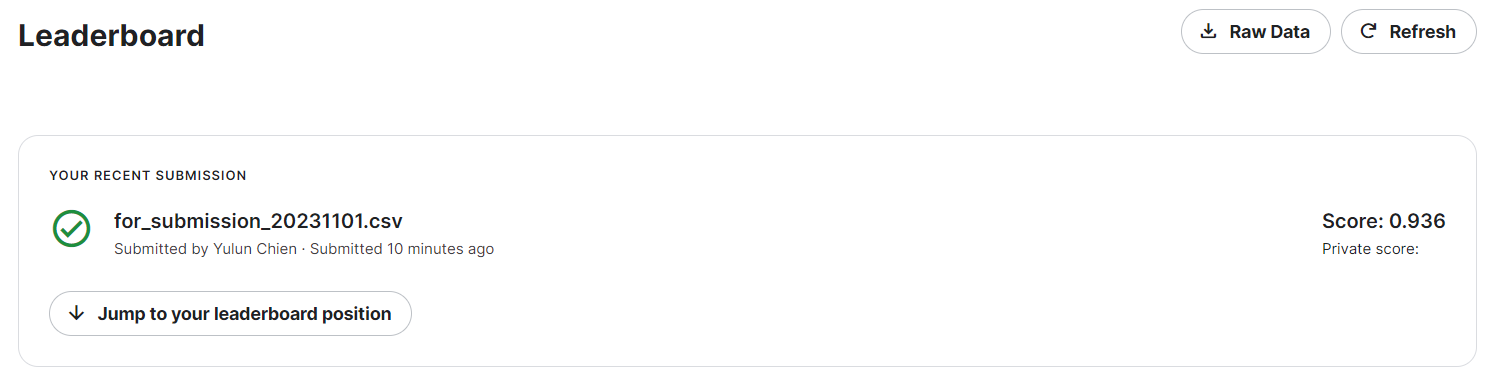

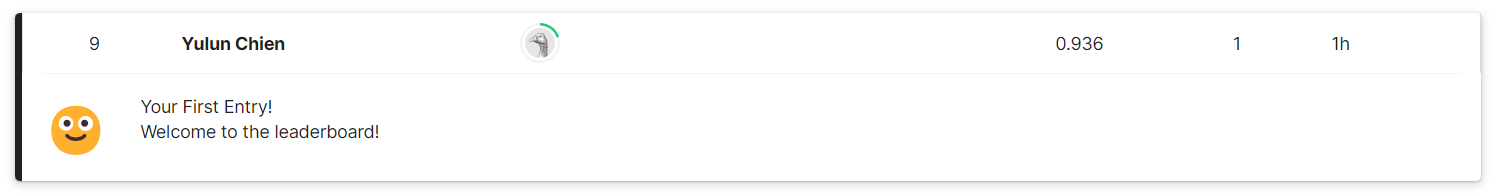

#### 關於預測結果
結果的accuracy score有0.98，我其實蠻意外，\
我擔心自己是不是features數量取太少\
但若取太多又會出現之前遇到的預測全0問題\
若之後有學到新的二元分類模型的話會想嘗試看看，\
是否能再提升其準確率？
#### 關於資料
其實原先全0的準確率就已經有0.84了\
讓我在思考這項competition的訓練資料是否太不平均\
其中眾多features的關聯性也都很低，\
不曉得若應用在更大量的資料上是否有用？
#### 實作心得
這份資料和titanic很相似，因此當初覺得應該不會有什麼問題，\
結果出來的預測一直都全0，\
後來發現是相關性都很低後，果斷就刪除了一堆features。\
但我在想是不是可以針對不同features做權重的調整？
或許能將關聯性相對低的features權重調低，相反的調高。